In [ ]:
!python -m pip install torch torchvision torchaudio

In [ ]:
# Find the CUDA version PyTorch was installed with
!python -c "import torch; print(torch.version.cuda)"

12.6


In [ ]:
# PyTorch version
!python -c "import torch; print(torch.__version__)"

2.8.0+cu126


In [ ]:
# Check out https://pytorch-geometric.readthedocs.io/en/latest/notes/installation.html
!python -m pip install pyg_lib torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-2.3.0+cu121.html
!python -m pip install torch_geometric
!python -m pip install rdkit

Looking in links: https://data.pyg.org/whl/torch-2.3.0+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 83.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 118.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 119.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 127.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 949.6/949.6 kB 66.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 80.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.2/36.2 MB 15.8 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.datasets import MoleculeNet
from torch_geometric.nn import MLP, GCNConv, GATv2Conv, global_add_pool

import rdkit
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image
import networkx as nx
from rdkit import Chem, RDLogger
from typing import List, Tuple, Union

/usr/local/lib/python3.12/dist-packages/torch_geometric/__init__.py:4: UserWarning: An issue occurred while importing 'pyg-lib'. Disabling its usage. Stacktrace: /usr/local/lib/python3.12/dist-packages/libpyg.so: undefined symbol: _ZNK5torch8autograd4Node4nameEv
  import torch_geometric.typing
/usr/local/lib/python3.12/dist-packages/torch_geometric/__init__.py:4: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: /usr/local/lib/python3.12/dist-packages/torch_scatter/_version_cuda.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKSs
  import torch_geometric.typing
/usr/local/lib/python3.12/dist-packages/torch_geometric/__init__.py:4: UserWarning: An issue occurred while importing 'torch-cluster'. Disabling its usage. Stacktrace: /usr/local/lib/python3.12/dist-packages/torch_cluster/_version_cuda.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKSs
  import torch_geometric.typing
/usr/local/lib/python3.12/dist-packages/torch_geo

In [ ]:
print(f"PyTorch: {torch.__version__}")
print(f"RDKit: {rdkit.__version__}")
print('__CUDNN VERSION:', torch.backends.cudnn.version())
print('__Number CUDA Devices:', torch.cuda.device_count())
if torch.cuda.is_available():
    print('__CUDA Device Name:',torch.cuda.get_device_name(0))
    print('__CUDA Device Total Memory [GB]:',torch.cuda.get_device_properties(0).total_memory/1e9)

PyTorch: 2.8.0+cu126
RDKit: 2025.09.1
__CUDNN VERSION: 91002
__Number CUDA Devices: 1
__CUDA Device Name: Tesla T4
__CUDA Device Total Memory [GB]: 15.828320256


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

device

device(type='cuda')

In [ ]:
# Routine to draw graph structure #Case 1:All nodes and edges identical

def draw_graph_structure(adjacency_matrix, color=None):

    G = nx.Graph()
    n_node = adjacency_matrix.shape[0]
    for i in range(n_node):
      for j in range(i):
        if adjacency_matrix[i,j]:
            G.add_edge(i,j)

    if color is None:
        nx.draw(G, nx.spring_layout(G, seed = 0), with_labels=True)
    else:
        nx.draw(G, nx.spring_layout(G, seed = 0), with_labels=True, node_color=color)
    plt.show()

[[0 1 0 1 0 0 0 0]
 [1 0 1 1 1 0 0 0]
 [0 1 0 0 1 0 0 0]
 [1 1 0 0 1 0 0 0]
 [0 1 1 1 0 1 0 1]
 [0 0 0 0 1 0 1 1]
 [0 0 0 0 0 1 0 0]
 [0 0 0 0 1 1 0 0]]


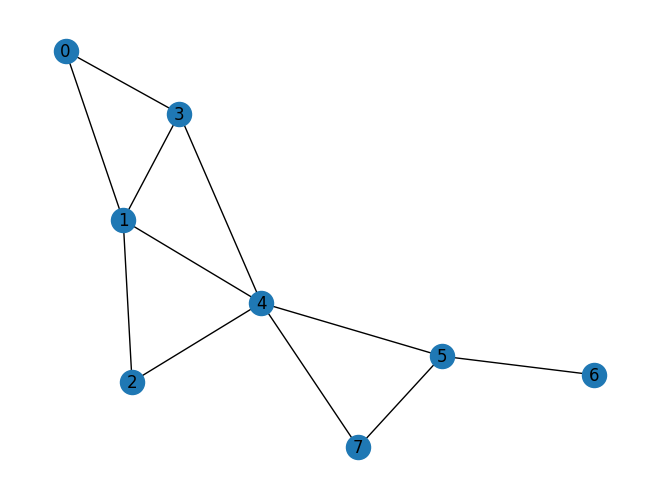

In [ ]:
# An adjacency matrix define a graph
# A (adjacency matrix) of shape (num_nodes, num_nodes)
A = np.array([[0,1,0,1,0,0,0,0],
              [1,0,1,1,1,0,0,0],
              [0,1,0,0,1,0,0,0],
              [1,1,0,0,1,0,0,0],
              [0,1,1,1,0,1,0,1],
              [0,0,0,0,1,0,1,1],
              [0,0,0,0,0,1,0,0],
              [0,0,0,0,1,1,0,0]]);
print(A)
draw_graph_structure(A)

[[1]
 [0]
 [1]
 [2]
 [2]
 [0]
 [1]
 [1]]
[[0 1 0 1 0 0 0 0]
 [1 0 1 1 1 0 0 0]
 [0 1 0 0 1 0 0 0]
 [1 1 0 0 1 0 0 0]
 [0 1 1 1 0 1 0 1]
 [0 0 0 0 1 0 1 1]
 [0 0 0 0 0 1 0 0]
 [0 0 0 0 1 1 0 0]]


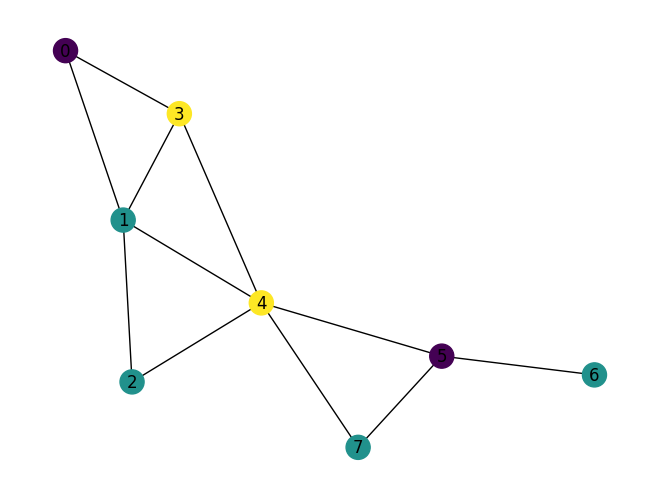

In [ ]:
#Case2: Nodes not identical but edges identical
# Node features and adjacency matrix define a graph
# A (adjacency matrix) of shape (num_nodes, num_nodes)
# H (Node features matrix) of shape (num_nodes, dim_nodes)
A = np.array([[0,1,0,1,0,0,0,0],
              [1,0,1,1,1,0,0,0],
              [0,1,0,0,1,0,0,0],
              [1,1,0,0,1,0,0,0],
              [0,1,1,1,0,1,0,1],
              [0,0,0,0,1,0,1,1],
              [0,0,0,0,0,1,0,0],
              [0,0,0,0,1,1,0,0]])

H = np.array([
    [1],
    [0],
    [1],
    [2],
    [2],
    [0],
    [1],
    [1]
])
print(H)
print(A)
draw_graph_structure(A, color=H)


In [ ]:
#Case3: neither nodes or edges identical
# An adjacency matrix define a graph
# A (adjacency matrix) of shape (num_nodes, num_nodes)
# H (Node features matrix) of shape (num_nodes, dim_nodes)
# E (Edge features tensor) of shape (num_nodes, num_nodes, dim_edges)
A = np.array([[0,1,0,1,0,0,0,0],
              [1,0,1,1,1,0,0,0],
              [0,1,0,0,1,0,0,0],
              [1,1,0,0,1,0,0,0],
              [0,1,1,1,0,1,0,1],
              [0,0,0,0,1,0,1,1],
              [0,0,0,0,0,1,0,0],
              [0,0,0,0,1,1,0,0]])

H = np.array([
    [1],
    [0],
    [1],
    [2],
    [2],
    [0],
    [1],
    [1]
])
E = np.zeros((H.shape[0], H.shape[0], 2))
for i in range(H.shape[0]):
    for j in range(H.shape[0]):
        if A[i, j] == 1:
            E[i, j, 0] = H[i, 0]
            E[i, j, 1] = H[j, 0]

print(f"Adjacency matrix: \n{A}")
print(f"Node features matrix: \n{H}")
print(f"Edge features tensor: \n{E}")



Adjacency matrix: 
[[0 1 0 1 0 0 0 0]
 [1 0 1 1 1 0 0 0]
 [0 1 0 0 1 0 0 0]
 [1 1 0 0 1 0 0 0]
 [0 1 1 1 0 1 0 1]
 [0 0 0 0 1 0 1 1]
 [0 0 0 0 0 1 0 0]
 [0 0 0 0 1 1 0 0]]
Node features matrix: 
[[1]
 [0]
 [1]
 [2]
 [2]
 [0]
 [1]
 [1]]
Edge features tensor: 
[[[0. 0.]
  [1. 0.]
  [0. 0.]
  [1. 2.]
  [0. 0.]
  [0. 0.]
  [0. 0.]
  [0. 0.]]

 [[0. 1.]
  [0. 0.]
  [0. 1.]
  [0. 2.]
  [0. 2.]
  [0. 0.]
  [0. 0.]
  [0. 0.]]

 [[0. 0.]
  [1. 0.]
  [0. 0.]
  [0. 0.]
  [1. 2.]
  [0. 0.]
  [0. 0.]
  [0. 0.]]

 [[2. 1.]
  [2. 0.]
  [0. 0.]
  [0. 0.]
  [2. 2.]
  [0. 0.]
  [0. 0.]
  [0. 0.]]

 [[0. 0.]
  [2. 0.]
  [2. 1.]
  [2. 2.]
  [0. 0.]
  [2. 0.]
  [0. 0.]
  [2. 1.]]

 [[0. 0.]
  [0. 0.]
  [0. 0.]
  [0. 0.]
  [0. 2.]
  [0. 0.]
  [0. 1.]
  [0. 1.]]

 [[0. 0.]
  [0. 0.]
  [0. 0.]
  [0. 0.]
  [0. 0.]
  [1. 0.]
  [0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]
  [0. 0.]
  [0. 0.]
  [1. 2.]
  [1. 0.]
  [0. 0.]
  [0. 0.]]]


A graph data in PyG can be seen as a dictionary with different attributes as keys and corresponding tensors as values. By default, a graph has following attributes:

    data.x: Node feature matrix with shape [num_nodes, num_node_features]
    data.edge_index: Graph connectivity in COO format with shape [2, num_edges]
    data.edge_attr: Edge feature matrix with shape [num_edges, num_edge_features]
    data.y: Target to train against (may have arbitrary shape), e.g., node-level targets of shape [num_nodes, *] or graph-level targets of shape [1, *]
    data.pos: Node position matrix with shape [num_nodes, num_dimensions]



In [ ]:
from torch_geometric.data import Data

# define node features
x = torch.tensor([[-1], [0], [1]])

# define edge list
edge_index = torch.tensor(
    [[0, 1, 1, 2],
     [1, 0, 2, 1]])

# A = [
#     [0, 1, 0],
#     [1, 0, 1],
#     [0, 1, 0],
# ]

# create graph data object
data = Data(x=x, edge_index=edge_index)
print(data)

Data(x=[3, 1], edge_index=[2, 4])


In [ ]:
for key, item in data:
    print(f'{key} found in data: {item}')

x found in data: tensor([[-1],
        [ 0],
        [ 1]])
edge_index found in data: tensor([[0, 1, 1, 2],
        [1, 0, 2, 1]])


In [ ]:
# create graph data object
data = Data()

# define edge list
data.edge_index = torch.tensor([[0, 1, 1, 2], [1, 0, 2, 1]])

# define node features
data.x = torch.tensor([[-1], [0], [1]])

print(data)

Data(edge_index=[2, 4], x=[3, 1])


In [ ]:
for key, item in data:
    print(f'{key} found in data: {item}')

edge_index found in data: tensor([[0, 1, 1, 2],
        [1, 0, 2, 1]])
x found in data: tensor([[-1],
        [ 0],
        [ 1]])


In [ ]:
# Check what attributes
print(data.keys())

['x', 'edge_index']


In [ ]:
# check number of edges of the graph
print(data.num_edges)

4


In [ ]:
# check number of nodes of the graph
print(data.num_nodes)

3


In [ ]:
# check number of features of the graph
print(data.num_features)

1


In [ ]:
# check if there are edge features in the graph
'edge_attr' in data

False

In [ ]:
# check if graph is directed
print(data.is_directed())

False


In [ ]:
# fetch the internal data
data['x'], data['edge_index']

(tensor([[-1],
         [ 0],
         [ 1]]),
 tensor([[0, 1, 1, 2],
         [1, 0, 2, 1]]))

In [ ]:
# fetch the internal data
data.x, data.edge_index

(tensor([[-1],
         [ 0],
         [ 1]]),
 tensor([[0, 1, 1, 2],
         [1, 0, 2, 1]]))

In [ ]:
# You can transfer all matrice together to GPU
data.to(device)
data.x, data.edge_index

(tensor([[-1],
         [ 0],
         [ 1]], device='cuda:0'),
 tensor([[0, 1, 1, 2],
         [1, 0, 2, 1]], device='cuda:0'))

In [ ]:
# You can add any label to the graph data
data.special = 'something'
data.another = torch.randn(data.num_nodes, 2)
data

Data(edge_index=[2, 4], x=[3, 1], special='something', another=[3, 2])

In [ ]:
# Internal data within a graph data can be on different devices
data.x, data.edge_index, data.special, data.another

(tensor([[-1],
         [ 0],
         [ 1]], device='cuda:0'),
 tensor([[0, 1, 1, 2],
         [1, 0, 2, 1]], device='cuda:0'),
 'something',
 tensor([[ 0.7726,  1.3292],
         [-1.1595, -0.8579],
         [-0.1452, -0.7400]]))

In [ ]:
data.to(device)
data.x, data.edge_index, data.special, data.another

(tensor([[-1],
         [ 0],
         [ 1]], device='cuda:0'),
 tensor([[0, 1, 1, 2],
         [1, 0, 2, 1]], device='cuda:0'),
 'something',
 tensor([[ 0.7726,  1.3292],
         [-1.1595, -0.8579],
         [-0.1452, -0.7400]], device='cuda:0'))

In [ ]:
from torch_geometric.loader import DataLoader

g = Data(x=torch.randn(3, 4), edge_index=torch.tensor([[0, 1, 1, 2], [1, 0, 2, 1]]))
loader = DataLoader([g] * 32, batch_size=4, shuffle=True)

batch = next(iter(loader))

print(g)
print(batch)

Data(x=[3, 4], edge_index=[2, 4])
DataBatch(x=[12, 4], edge_index=[2, 16], batch=[12], ptr=[5])


In [ ]:
print(g.x)
print(batch.x)

tensor([[ 0.2322,  0.0711, -1.2150, -2.9585],
        [ 0.2416,  0.3750, -2.1952,  0.1005],
        [ 0.4371,  1.6424,  0.0830,  0.4869]])
tensor([[ 0.2322,  0.0711, -1.2150, -2.9585],
        [ 0.2416,  0.3750, -2.1952,  0.1005],
        [ 0.4371,  1.6424,  0.0830,  0.4869],
        [ 0.2322,  0.0711, -1.2150, -2.9585],
        [ 0.2416,  0.3750, -2.1952,  0.1005],
        [ 0.4371,  1.6424,  0.0830,  0.4869],
        [ 0.2322,  0.0711, -1.2150, -2.9585],
        [ 0.2416,  0.3750, -2.1952,  0.1005],
        [ 0.4371,  1.6424,  0.0830,  0.4869],
        [ 0.2322,  0.0711, -1.2150, -2.9585],
        [ 0.2416,  0.3750, -2.1952,  0.1005],
        [ 0.4371,  1.6424,  0.0830,  0.4869]])


In [ ]:
print(g.edge_index)
print(batch.edge_index)

tensor([[0, 1, 1, 2],
        [1, 0, 2, 1]])
tensor([[ 0,  1,  1,  2,  3,  4,  4,  5,  6,  7,  7,  8,  9, 10, 10, 11],
        [ 1,  0,  2,  1,  4,  3,  5,  4,  7,  6,  8,  7, 10,  9, 11, 10]])


In [ ]:
# Batch is a column vector which maps each node to its respective graph in the batch
batch.batch

tensor([0, 0, 0, 1, 1, 1, 2, 2, 2, 3, 3, 3])

In [ ]:
# A monotonically increasing pointer tensor that refers to the boundaries of segments
batch.ptr

tensor([ 0,  3,  6,  9, 12])

In [ ]:
from torch_geometric.datasets import MoleculeNet

# ESOL is a water solubility prediction dataset consisting of 1128 samples: https://moleculenet.org/datasets-1
dataset = MoleculeNet(root='tmp/ESOL', name='ESOL')

Processing...
Done!


In [ ]:
# number of graphs
print("Number of graphs: ", len(dataset))

# number of features
print("Number of features: ", dataset.num_features)

# number of classes
print("Number of classes: ", dataset.num_classes)

Number of graphs:  1128
Number of features:  9
Number of classes:  734


In [ ]:
# select the first graph
data = dataset[0]

# number of nodes
print("Number of nodes: ", data.num_nodes)

# number of edges
print("Number of edges: ", data.num_edges)

# check if directed
print("Is directed: ", data.is_directed())

Number of nodes:  32
Number of edges:  68
Is directed:  False


In [ ]:
data

Data(x=[32, 9], edge_index=[2, 68], edge_attr=[68, 3], smiles='OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)C(O)C3O ', y=[1, 1])

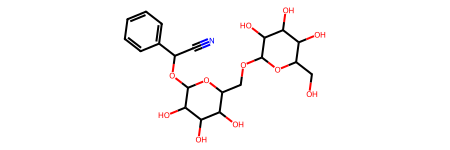

In [ ]:
from rdkit import Chem

Chem.MolFromSmiles(data.smiles)

In [ ]:
data.x

tensor([[8, 0, 2, 5, 1, 0, 4, 0, 0],
        [6, 0, 4, 5, 2, 0, 4, 0, 0],
        [6, 0, 4, 5, 1, 0, 4, 0, 1],
        [8, 0, 2, 5, 0, 0, 4, 0, 1],
        [6, 0, 4, 5, 1, 0, 4, 0, 1],
        [8, 0, 2, 5, 0, 0, 4, 0, 0],
        [6, 0, 4, 5, 2, 0, 4, 0, 0],
        [6, 0, 4, 5, 1, 0, 4, 0, 1],
        [8, 0, 2, 5, 0, 0, 4, 0, 1],
        [6, 0, 4, 5, 1, 0, 4, 0, 1],
        [8, 0, 2, 5, 0, 0, 4, 0, 0],
        [6, 0, 4, 5, 1, 0, 4, 0, 0],
        [6, 0, 2, 5, 0, 0, 2, 0, 0],
        [7, 0, 1, 5, 0, 0, 2, 0, 0],
        [6, 0, 3, 5, 0, 0, 3, 1, 1],
        [6, 0, 3, 5, 1, 0, 3, 1, 1],
        [6, 0, 3, 5, 1, 0, 3, 1, 1],
        [6, 0, 3, 5, 1, 0, 3, 1, 1],
        [6, 0, 3, 5, 1, 0, 3, 1, 1],
        [6, 0, 3, 5, 1, 0, 3, 1, 1],
        [6, 0, 4, 5, 1, 0, 4, 0, 1],
        [8, 0, 2, 5, 1, 0, 4, 0, 0],
        [6, 0, 4, 5, 1, 0, 4, 0, 1],
        [8, 0, 2, 5, 1, 0, 4, 0, 0],
        [6, 0, 4, 5, 1, 0, 4, 0, 1],
        [8, 0, 2, 5, 1, 0, 4, 0, 0],
        [6, 0, 4, 5, 1, 0, 4, 0, 1],
 

In [ ]:
data.edge_attr

tensor([[ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 3,  0,  0],
        [ 3,  0,  0],
        [ 1,  0,  0],
        [12,  0,  1],
        [12,  0,  1],
        [12,  0,  1],
        [12,  0,  1],
        [12,  0,  1],
        [12,  0,  1],
        [12,  0,  1],
        [12,  0,  1],
        [12,  0,  1],
        [12,  0,  1],
        [12,  0,  1],
        [12,  0,  1],
        [ 1,  0,  0],
        [ 

In [ ]:
data.y

tensor([[-0.7700]])

In [ ]:
train_dataset = dataset[:800]
test_dataset = dataset[800:]

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

In [ ]:
data_batch = next(iter(train_loader))
print(data_batch)

DataBatch(x=[1617, 9], edge_index=[2, 3314], edge_attr=[3314, 3], smiles=[128], y=[128, 1], batch=[1617], ptr=[129])


In [ ]:
data_batch.batch

tensor([  0,   0,   0,  ..., 127, 127, 127])

In [ ]:
data.edge_attr

tensor([[ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 3,  0,  0],
        [ 3,  0,  0],
        [ 1,  0,  0],
        [12,  0,  1],
        [12,  0,  1],
        [12,  0,  1],
        [12,  0,  1],
        [12,  0,  1],
        [12,  0,  1],
        [12,  0,  1],
        [12,  0,  1],
        [12,  0,  1],
        [12,  0,  1],
        [12,  0,  1],
        [12,  0,  1],
        [ 1,  0,  0],
        [ 

In [ ]:
data_batch = next(iter(train_loader))
print(data_batch)

DataBatch(x=[1610, 9], edge_index=[2, 3334], edge_attr=[3334, 3], smiles=[128], y=[128, 1], batch=[1610], ptr=[129])


Equivariance & Invariance in Graph Neural Networks

Equivariance:If we transform the input with ( g ), and then apply the layer, it's the same as applying the layer first and then transforming the output.

Invariance:If we transform the input with ( g ), the output doesn't change — it stays the same.

In GNNs, we care a lot about how the structure or ordering of a graph affects the results.

Imagine 3 friends in a group chat:Each has a profile (age, interests, etc.). A GNN processes their connections to predict influence score.

Permutation Equivariance:
If we swap the order of Alice and Carol in the input, the GNN will still compute the right influence scores — just in the swapped order.Output changes predictably when input changes.

Permutation Invariance:
Suppose we want to predict whether this group is likely to go viral (a group-level output).It shouldn’t matter if Alice is listed first or Carol — the output (yes/no) stays the same.


Graph Convolution Network
Let's begin with one of the most simple GNN operators, the GCN layer (Kipf et al. (2017)). The graph convolution operation is defined as:
$$
\mathbf{x}^{\prime}_i = \mathbf{\Theta}^{\top} \sum_{j \in
\mathcal{N}(i) \cup \{ i \}} \frac{e_{j,i}}{\sqrt{\hat{d}_j
\hat{d}_i}} \mathbf{x}_j
$$

with $\hat{d}_i = 1 + \sum_{j \in \mathcal{N}(i)} e_{j,i}$, where $e_{j,i}$ denotes the edge weight from source node to target node

.

The matrix form is:
$$
\mathbf{X}^{\prime} = \mathbf{\hat{D}}^{-1/2} \mathbf{\hat{A}}
\mathbf{\hat{D}}^{-1/2} \mathbf{X} \mathbf{\Theta}
$$

where $\mathbf{\hat{A}} = \mathbf{A} + \mathbf{I}$ denotes the adjacency matrix with inserted self-loops and $\hat{D}_{ii} = \sum_{j=0} \hat{A}_{ij}$ its diagonal degree matrix. $e_{j,i} = \mathcal{A}_{ij}$ indicates the adjacency matrix can include other values than $1$ representing edge weights.

Now consider a simple case, all edges are identical and only consider neighbor nodes:

$$
\mathbf{X}^{\prime} = \mathbf{A} \mathbf{X} \mathbf{\Theta}
$$


In [ ]:
class Our_GCNLayer(nn.Module):
    """
    Simple GCN layer, similar to https://arxiv.org/abs/1609.02907
    Implementation is referenced https://github.com/tkipf/pygcn/tree/master
    """

    def __init__(self, input_dim, output_dim, bias=True):
        """
        A graph convolution layer.

        Args:
          input_dim: Input feature dimension
          output_dim: Output feature dimension
          bias: Whether to include bias term
        """
        super(Our_GCNLayer, self).__init__()

        self.lin = nn.Linear(input_dim, output_dim, bias=False)

        if bias:
            self.bias = nn.Parameter(torch.rand(output_dim))
        else:
            self.register_parameter('bias', None)

    def forward(self, x, adj_pyg):
        """
        Args:
          x: Node feature matrix of shape [num_nodes, input_dim]
          adj_pyg: Adjacency matrix of shape in COO sparse format [2, num_edges]
        """

        support = self.lin(x)

        adj = torch.sparse_coo_tensor(adj_pyg, torch.ones(adj_pyg.shape[1]), [x.shape[0], x.shape[0]])
        output = torch.spmm(adj, support)

        if self.bias is not None:
            return output + self.bias
        else:
            return output

In [ ]:
data

Data(x=[32, 9], edge_index=[2, 68], edge_attr=[68, 3], smiles='OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)C(O)C3O ', y=[1, 1])

In [ ]:
gcn_layer = Our_GCNLayer(input_dim=9, output_dim=16)
gcn_layer

Our_GCNLayer(
  (lin): Linear(in_features=9, out_features=16, bias=False)
)

In [ ]:
test_node_feature = torch.randn(3, 9)
test_adj_matrix = torch.tensor([[0, 1, 1, 2], [1, 0, 2, 1]])
test_node_feature, test_adj_matrix

(tensor([[-0.8547,  0.5807, -0.2753, -0.3214, -0.8054,  1.4080, -0.3925,  0.9289,
          -0.9265],
         [-0.7776, -1.1297, -0.1928, -0.6812,  1.7139, -0.3062, -0.5377,  0.4010,
          -0.7461],
         [-2.2431,  0.1985, -0.5420,  0.7973,  1.0873, -1.4844, -1.2651, -0.8261,
           1.2727]]),
 tensor([[0, 1, 1, 2],
         [1, 0, 2, 1]]))

In [ ]:
gcn_layer(test_node_feature, test_adj_matrix)

tensor([[ 0.7106,  0.4219,  1.3256,  0.2365,  1.5168,  0.3172,  0.5785,  0.4984,
          1.3033,  0.6894,  0.1681,  1.5482,  1.1418,  0.1742,  0.6924,  1.3299],
        [ 1.6753,  0.7139,  1.6134,  0.8692,  1.1954,  1.8213,  0.6850, -0.3019,
          1.5084,  0.9773,  0.4551,  1.3332,  1.5868,  1.1746,  1.7649,  0.8111],
        [ 0.7106,  0.4219,  1.3256,  0.2365,  1.5168,  0.3172,  0.5785,  0.4984,
          1.3033,  0.6894,  0.1681,  1.5482,  1.1418,  0.1742,  0.6924,  1.3299]],
       grad_fn=<AddBackward0>)

In [ ]:
gcn_layer(test_node_feature, test_adj_matrix).shape

torch.Size([3, 16])

Information aggregation/ Graph Pooling

Following the equivariant layers, we will have learned embeddings for nodes (and edges). To perform graph-level prediction tasks, we need a invariant operation to aggregate the information, which is called graph pooling.

Literatures demonstrate that the choice of aggregation functions contributes significantly to the representational power and performance of the model. For example, mean aggregation captures the distribution (or proportions) of elements, max aggregation proves to be advantageous to identify representative elements, and sum aggregation enables the learning of structural graph properties (Xu et al. (2018)).

Now, let's implement a sum aggregation function:


In [ ]:
def our_add_pool(x, batch=None):

    if batch is None:
        return x.sum(dim=0, keepdim=True)
    else:
        # For simplicity, let's work with single graph only.
        pass

In [ ]:
x_test = torch.randn(2, 3)
x_test

tensor([[-0.2091, -0.4046, -2.6758],
        [-0.9667, -1.5823,  0.0749]])

In [ ]:
our_add_pool(x_test)

tensor([[-1.1759, -1.9869, -2.6009]])

In [ ]:
#Build the Network
from torch_geometric.nn import MLP

class GCN_torch(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers):
        super(GCN_torch, self).__init__()
        """ GCNConv layers """

        self.convs = torch.nn.ModuleList()
        for _ in range(num_layers):
            self.convs.append(Our_GCNLayer(in_channels, hidden_channels))
            in_channels = hidden_channels

        self.readout = MLP([hidden_channels, hidden_channels, out_channels], norm=None, dropout=0.5)

    def forward(self, data):

        x, edge_index, batch = data.x.to(torch.float), data.edge_index, data.batch

        for conv in self.convs:
            x = conv(x, edge_index).relu()

        return self.readout(our_add_pool(x, batch))

In [ ]:
data

Data(x=[32, 9], edge_index=[2, 68], edge_attr=[68, 3], smiles='OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)C(O)C3O ', y=[1, 1])

In [ ]:
gcn_torch = GCN_torch(in_channels=9, hidden_channels=16, out_channels=1, num_layers=2)
gcn_torch

GCN_torch(
  (convs): ModuleList(
    (0): Our_GCNLayer(
      (lin): Linear(in_features=9, out_features=16, bias=False)
    )
    (1): Our_GCNLayer(
      (lin): Linear(in_features=16, out_features=16, bias=False)
    )
  )
  (readout): MLP(16, 16, 1)
)

In [ ]:
gcn_torch(data)

tensor([[15.2481]], grad_fn=<AddmmBackward0>)

Up to now, we just use PyTorch to build the network. PyG implements this layer via GCNConv, which can be executed by passing in the node feature representation x and the COO graph connectivity representation edge_index. PyG also provide various aggregation function, including sum pooling by global_add_pool.

With this, we are able to create the network by calling the predefined layers and functions:


In [ ]:
class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers):
        super(GCN, self).__init__()
        """ GCNConv layers """

        self.convs = torch.nn.ModuleList()
        for _ in range(num_layers):
            self.convs.append(GCNConv(in_channels, hidden_channels, normalize=False))
            in_channels = hidden_channels

        self.readout = MLP([hidden_channels, hidden_channels, out_channels], norm=None, dropout=0.5)

    def forward(self, data):

        x, edge_index, batch = data.x.to(torch.float), data.edge_index, data.batch

        for conv in self.convs:
            x = conv(x, edge_index).relu()

        return self.readout(global_add_pool(x, batch))

In [ ]:
gcn_pyg = GCN(in_channels=9, hidden_channels=16, out_channels=1, num_layers=2)
gcn_pyg

GCN(
  (convs): ModuleList(
    (0): GCNConv(9, 16)
    (1): GCNConv(16, 16)
  )
  (readout): MLP(16, 16, 1)
)

In [ ]:
gcn_pyg(data)

tensor([[-55.4401]], grad_fn=<AddmmBackward0>)

In [ ]:
for name, param in gcn_pyg.named_parameters():
    print(name, param.data)

convs.0.bias tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
convs.0.lin.weight tensor([[-0.2677, -0.4001, -0.4553, -0.4054,  0.1709,  0.4500,  0.4591, -0.3672,
          0.3230],
        [ 0.4571, -0.3134, -0.1551, -0.1122,  0.1835, -0.2432, -0.4559, -0.3193,
         -0.2160],
        [-0.2901,  0.3833,  0.2021, -0.2175,  0.2322, -0.2060, -0.1248,  0.1478,
          0.1130],
        [ 0.2139, -0.2921,  0.1727, -0.1461,  0.4525, -0.0307, -0.3774,  0.2539,
         -0.2527],
        [ 0.1824,  0.0638, -0.0971, -0.3187, -0.0584, -0.4121,  0.1428,  0.4380,
         -0.2221],
        [-0.2818,  0.1500,  0.0720,  0.3550, -0.2253, -0.1059,  0.3858,  0.2462,
         -0.3739],
        [ 0.3244, -0.4308, -0.3019,  0.2155,  0.4409,  0.4765,  0.2666, -0.0872,
          0.1654],
        [ 0.1118, -0.1045,  0.2152, -0.2724,  0.1545,  0.1134, -0.2593, -0.0147,
          0.1414],
        [-0.4426,  0.0021,  0.4628,  0.1895, -0.0121, -0.4361,  0.2312, -0.2377,
         -0.18

In [ ]:
for name, param in gcn_torch.named_parameters():
    print(name, param.data)

convs.0.bias tensor([0.7038, 0.3283, 0.2274, 0.9463, 0.9673, 0.2219, 0.5283, 0.3621, 0.3799,
        0.0491, 0.3155, 0.3286, 0.7166, 0.8682, 0.1957, 0.2101])
convs.0.lin.weight tensor([[-3.2814e-01,  1.0522e-01, -7.2216e-02, -1.4879e-01, -1.5950e-01,
          2.7867e-01,  2.3276e-01, -1.8612e-01,  3.7097e-02],
        [ 1.9449e-01,  1.9234e-01,  1.8856e-02, -1.4859e-01, -1.9587e-02,
         -1.6123e-01,  2.9070e-01,  2.4933e-01, -1.6310e-02],
        [-3.2723e-01,  1.8696e-01,  2.9084e-01, -1.7430e-01, -6.6573e-03,
         -1.4847e-01, -2.6151e-01,  3.1203e-01,  2.1278e-01],
        [-2.5141e-04, -1.0969e-01,  2.1071e-01, -2.2884e-01,  1.6705e-01,
         -1.6378e-01,  7.5667e-02, -6.2680e-02, -5.1067e-02],
        [-1.7776e-01, -1.2033e-01,  2.8867e-01,  1.2194e-01,  1.2655e-01,
          1.7342e-02,  4.7859e-02, -2.0702e-02,  1.0294e-01],
        [ 2.3875e-01, -1.4666e-01, -2.5369e-01,  2.5147e-01,  1.6969e-01,
          2.0220e-01, -3.2425e-01,  5.7229e-02,  2.3590e-01],
       

In [ ]:
gcn_pyg.load_state_dict(gcn_torch.state_dict())
gcn_pyg.eval()
gcn_torch.eval()
gcn_pyg(data), gcn_torch(data)

(tensor([[10.7905]], grad_fn=<AddmmBackward0>),
 tensor([[10.7905]], grad_fn=<AddmmBackward0>))

Training a GNN

# Define our model
model = MyNeuralNetwork(...)

# Choose our optimizer
optimizer = torch.optim.SGD(
  model.parameters(), lr=0.01, momentum=0.9
)

for epoch in range(num_epochs):
    # Loop over a DataLoader
    for batch_idx, batch in enumerate(train_loader):

        # Unpack the data
        features, targets = batch

        # Zero the gradients for every batch
        optimizer.zero_grad()
            
        # Make predictions for this batch
        forward_pass_outputs = model(features)

        # Compute the loss and its gradients
        loss = loss_fn(forward_pass_outputs, targets)

        # Compute the gradients via back propagation
        loss.backward()
        
        # Updates the weights through optimization
        optimizer.step()


Training a GNN is the same in PyTorch/PyG

In [ ]:
epochs = 50
hidden_channels = 64
num_layers = 5
lr = 0.0005

model = GCN(in_channels=9, hidden_channels=hidden_channels, out_channels=1, num_layers=num_layers).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

train_loss_list = []
val_lost_list = []

for epcoh in range(1, epochs + 1):
        # Train
        model.train()
        for data_minibatch in train_loader:
                data_minibatch = data_minibatch.to(device)
                optimizer.zero_grad()
                out = model(data_minibatch)
                loss = F.l1_loss(out, data_minibatch.y)
                loss.backward()
                optimizer.step()

        # Evaluate on training set
        model.eval()
        total_loss_train = 0
        for data_minibatch in train_loader:
                data_minibatch = data_minibatch.to(device)
                pred = model(data_minibatch)
                loss = F.l1_loss(pred, data_minibatch.y)
                total_loss_train += float(loss) * data_minibatch.num_graphs

        # Evaluate on test set
        model.eval()
        total_loss_test = 0
        for data_minibatch in test_loader:
                data_minibatch = data_minibatch.to(device)
                pred = model(data_minibatch)
                loss = F.l1_loss(pred, data_minibatch.y)
                total_loss_test += float(loss) * data_minibatch.num_graphs

        total_loss_train = total_loss_train / len(train_dataset)
        total_loss_test = total_loss_test / len(test_dataset)

        train_loss_list.append(total_loss_train)
        val_lost_list.append(total_loss_test)

        print(f'Epoch: {epcoh:03d}, Train MAE: {total_loss_train:.4f}, Test MAE: {total_loss_test:.4f}')

/tmp/ipython-input-818260027.py:30: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /pytorch/torch/csrc/autograd/generated/python_variable_methods.cpp:835.)
  total_loss_train += float(loss) * data_minibatch.num_graphs


Epoch: 001, Train MAE: 7.7392, Test MAE: 7.6491
Epoch: 002, Train MAE: 3.7587, Test MAE: 3.7997
Epoch: 003, Train MAE: 2.6475, Test MAE: 2.5600
Epoch: 004, Train MAE: 1.8491, Test MAE: 1.9349
Epoch: 005, Train MAE: 2.2321, Test MAE: 2.2875
Epoch: 006, Train MAE: 1.7270, Test MAE: 1.7502
Epoch: 007, Train MAE: 1.5038, Test MAE: 1.5879
Epoch: 008, Train MAE: 1.2901, Test MAE: 1.2781
Epoch: 009, Train MAE: 1.2289, Test MAE: 1.3018
Epoch: 010, Train MAE: 1.1301, Test MAE: 1.1852
Epoch: 011, Train MAE: 1.1150, Test MAE: 1.1447
Epoch: 012, Train MAE: 1.1262, Test MAE: 1.1947
Epoch: 013, Train MAE: 1.1811, Test MAE: 1.2767
Epoch: 014, Train MAE: 1.1370, Test MAE: 1.1913
Epoch: 015, Train MAE: 1.0852, Test MAE: 1.0994
Epoch: 016, Train MAE: 1.0620, Test MAE: 1.0941
Epoch: 017, Train MAE: 1.0322, Test MAE: 1.1397
Epoch: 018, Train MAE: 1.1035, Test MAE: 1.1863
Epoch: 019, Train MAE: 0.9930, Test MAE: 1.0555
Epoch: 020, Train MAE: 1.0239, Test MAE: 1.0500
Epoch: 021, Train MAE: 1.0386, Test MAE:

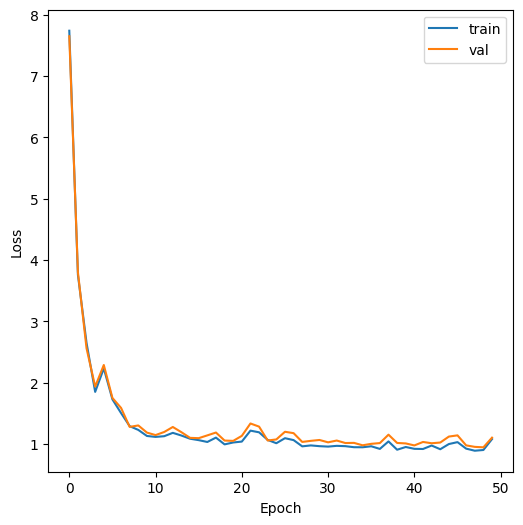

In [ ]:
# Plot learning curve
plt.figure(figsize=(6, 6))
plt.plot(train_loss_list, label='train')
plt.plot(val_lost_list, label='val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

RMSE =  1.4994566
R^2 =  0.50102144


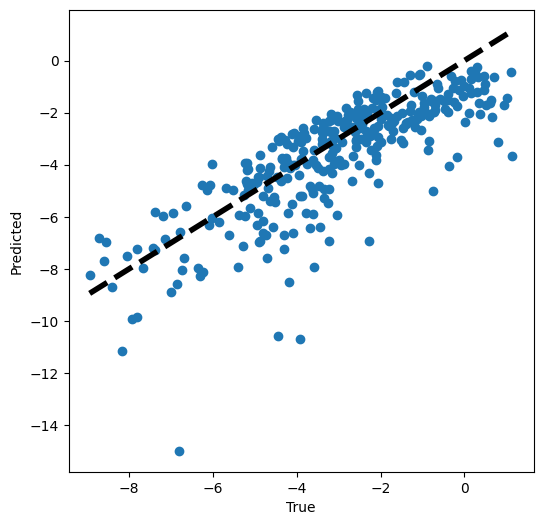

In [ ]:
y_true = []
y_pred = []
for data_minibatch in test_loader:
        data_minibatch = data_minibatch.to(device)
        pred = model(data_minibatch)
        y_true.append(data_minibatch.y.cpu().detach().numpy())
        y_pred.append(pred.cpu().detach().numpy())

y_true = np.concatenate(y_true)
y_pred = np.concatenate(y_pred)

RMSE = np.sqrt(np.mean((y_true - y_pred)**2))
print('RMSE = ', RMSE)

R_square = 1 - np.sum((y_true - y_pred)**2) / np.sum((y_true - np.mean(y_true))**2)
print('R^2 = ', R_square)

plt.figure(figsize=(6, 6))
plt.scatter(y_true, y_pred)
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'k--', lw=4)
plt.xlabel('True')
plt.ylabel('Predicted')
plt.show()

Graph Attention Networks

The node feature for node \( i \) is given by:

$$
\mathbf{x}^{\prime}_i = \sum_{j \in \mathcal{N}(i) \cup \{ i \}}
\alpha_{i,j} \, \mathbf{\Theta}_{t} \mathbf{x}_{j}
$$

where the attention coefficients are $( \alpha_{i,j} ) $ are computed as:

$$
\alpha_{i,j} =
\frac{
\exp\left(\mathbf{a}^{\top} \, \mathrm{LeakyReLU}\left(
\mathbf{\Theta}_{s} \mathbf{x}_i + \mathbf{\Theta}_{t} \mathbf{x}_j
\right)\right)}
{\sum_{k \in \mathcal{N}(i) \cup \{ i \}}
\exp\left(\mathbf{a}^{\top} \, \mathrm{LeakyReLU}\left(
\mathbf{\Theta}_{s} \mathbf{x}_i + \mathbf{\Theta}_{t} \mathbf{x}_k
\right)\right)}
$$

If the graph has multi-dimensional edge features \( \mathbf{e}_{i,j} \), the attention becomes:

$$
\alpha_{i,j} =
\frac{
\exp\left(\mathbf{a}^{\top} \, \mathrm{LeakyReLU}\left(
\mathbf{\Theta}_{s} \mathbf{x}_i
+ \mathbf{\Theta}_{t} \mathbf{x}_j
+ \mathbf{\Theta}_{e} \mathbf{e}_{i,j}
\right)\right)}
{\sum_{k \in \mathcal{N}(i) \cup \{ i \}}
\exp\left(\mathbf{a}^{\top} \, \mathrm{LeakyReLU}\left(
\mathbf{\Theta}_{s} \mathbf{x}_i
+ \mathbf{\Theta}_{t} \mathbf{x}_k
+ \mathbf{\Theta}_{e} \mathbf{e}_{i,k}
\right)\right)}
$$

**Note:**  
The matrices $( \mathbf{\Theta}_s)$, $( \mathbf{\Theta}_t)$, and $( \mathbf{\Theta}_e)$ are **learnable weights** that transform node and edge features before computing attention. By learning these transformations, the GNN can focus attention on the most relevant parts of the graph, helping it make more informed predictions.

In [ ]:
class GraphAttention(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers):
        super(GraphAttention, self).__init__()
        """ GATConv layers """

        self.convs = torch.nn.ModuleList()
        self.activation = nn.ReLU()
        for _ in range(num_layers):
            self.convs.append(GATv2Conv(in_channels, hidden_channels))
            in_channels = hidden_channels

        self.readout = MLP([hidden_channels, hidden_channels, out_channels], norm=None, dropout=0.5)

    def forward(self, data):

        x, edge_index, batch = data.x.to(torch.float), data.edge_index, data.batch

        for conv in self.convs:
            x, attention_weights = conv(x, edge_index,return_attention_weights = True)
            x = self.activation(x)

        return self.readout(global_add_pool(x, batch)), attention_weights

In [ ]:
epochs = 50
hidden_channels = 64
num_layers = 5
lr = 0.0005

model = GraphAttention(in_channels=9, hidden_channels=hidden_channels, out_channels=1, num_layers=num_layers).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

train_loss_list = []
val_lost_list = []

for epcoh in range(1, epochs + 1):
        # Train
        model.train()
        for data_minibatch in train_loader:
                data_minibatch = data_minibatch.to(device)
                optimizer.zero_grad()
                out, _ = model(data_minibatch)
                loss = F.l1_loss(out, data_minibatch.y)
                loss.backward()
                optimizer.step()

        # Evaluate on training set
        model.eval()
        total_loss_train = 0
        for data_minibatch in train_loader:
                data_minibatch = data_minibatch.to(device)
                pred, _ = model(data_minibatch)
                loss = F.l1_loss(pred, data_minibatch.y)
                total_loss_train += float(loss) * data_minibatch.num_graphs

        # Evaluate on test set
        model.eval()
        total_loss_test = 0
        for data_minibatch in test_loader:
                data_minibatch = data_minibatch.to(device)
                pred, _ = model(data_minibatch)
                loss = F.l1_loss(pred, data_minibatch.y)
                total_loss_test += float(loss) * data_minibatch.num_graphs

        total_loss_train = total_loss_train / len(train_dataset)
        total_loss_test = total_loss_test / len(test_dataset)

        train_loss_list.append(total_loss_train)
        val_lost_list.append(total_loss_test)

        print(f'Epoch: {epcoh:03d}, Train MAE: {total_loss_train:.4f}, Test MAE: {total_loss_test:.4f}')

Epoch: 001, Train MAE: 1.3983, Test MAE: 1.4040
Epoch: 002, Train MAE: 1.2865, Test MAE: 1.3436
Epoch: 003, Train MAE: 1.2207, Test MAE: 1.2736
Epoch: 004, Train MAE: 1.2101, Test MAE: 1.2468
Epoch: 005, Train MAE: 1.1768, Test MAE: 1.2375
Epoch: 006, Train MAE: 1.1436, Test MAE: 1.2042
Epoch: 007, Train MAE: 1.1470, Test MAE: 1.2150
Epoch: 008, Train MAE: 1.1170, Test MAE: 1.1807
Epoch: 009, Train MAE: 1.1117, Test MAE: 1.1599
Epoch: 010, Train MAE: 1.1130, Test MAE: 1.1651
Epoch: 011, Train MAE: 1.0772, Test MAE: 1.1356
Epoch: 012, Train MAE: 1.0752, Test MAE: 1.1366
Epoch: 013, Train MAE: 1.0488, Test MAE: 1.1012
Epoch: 014, Train MAE: 1.0544, Test MAE: 1.1135
Epoch: 015, Train MAE: 1.0061, Test MAE: 1.0594
Epoch: 016, Train MAE: 1.0041, Test MAE: 1.0748
Epoch: 017, Train MAE: 0.9609, Test MAE: 1.0123
Epoch: 018, Train MAE: 0.9356, Test MAE: 0.9795
Epoch: 019, Train MAE: 0.9059, Test MAE: 0.9667
Epoch: 020, Train MAE: 1.0313, Test MAE: 1.0987
Epoch: 021, Train MAE: 0.8988, Test MAE:

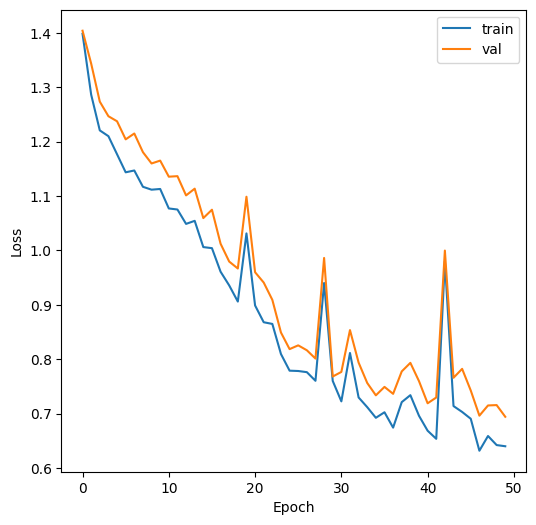

In [ ]:
# Plot learning curve
plt.figure(figsize=(6, 6))
plt.plot(train_loss_list, label='train')
plt.plot(val_lost_list, label='val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

RMSE =  0.9558681
R^2 =  0.797227


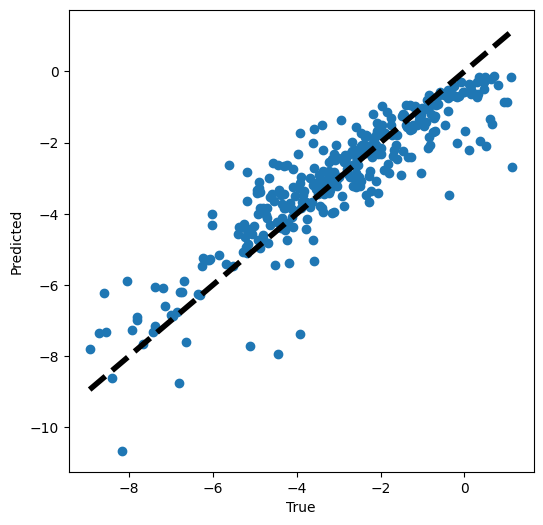

In [ ]:
y_true = []
y_pred = []
for data_minibatch in test_loader:
        data_minibatch = data_minibatch.to(device)
        pred,_ = model(data_minibatch)
        y_true.append(data_minibatch.y.cpu().detach().numpy())
        y_pred.append(pred.cpu().detach().numpy())

y_true = np.concatenate(y_true)
y_pred = np.concatenate(y_pred)

RMSE = np.sqrt(np.mean((y_true - y_pred)**2))
print('RMSE = ', RMSE)

R_square = 1 - np.sum((y_true - y_pred)**2) / np.sum((y_true - np.mean(y_true))**2)
print('R^2 = ', R_square)

plt.figure(figsize=(6, 6))
plt.scatter(y_true, y_pred)
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'k--', lw=4)
plt.xlabel('True')
plt.ylabel('Predicted')
plt.show()

Probing the Neural Network

One of the advantages of the GAT over other frameworks is that they allow for to check what the models are learning under the hood by inverstigating the attention maps. This allows us to correlate known facts with what the model has learnt and understand it better

In [ ]:
out, att_map = model(dataset[0].to(device))

In [ ]:
dataset[0]

Data(x=[32, 9], edge_index=[2, 68], edge_attr=[68, 3], smiles='OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)C(O)C3O ', y=[1, 1])

In [ ]:
att_map[1].shape

torch.Size([100, 1])

In [ ]:
att_map[0].shape

torch.Size([2, 100])

In [ ]:
smiles = dataset[0].smiles
mol = Chem.MolFromSmiles(smiles)


In [ ]:
# Create a mapping from atom pairs to bond indices
bond_map = {}
for bond in mol.GetBonds():
    i = bond.GetBeginAtomIdx()
    j = bond.GetEndAtomIdx()
    bond_map[(i, j)] = bond.GetIdx()
    bond_map[(j, i)] = bond.GetIdx()  # if undirected


In [ ]:
edge_index = att_map[0].cpu().numpy()
att_weights = att_map[1].cpu().detach().numpy().flatten()

# Normalize for coloring
att_norm = (att_weights - att_weights.min()) / (att_weights.max() - att_weights.min() + 1e-8)


In [ ]:
from matplotlib import colormaps
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import AllChem
from matplotlib.colors import Normalize
from matplotlib import colormaps
from PIL import Image as PILImage
import io
import matplotlib.pyplot as plt
import matplotlib.cm as cm


In [ ]:
cmap = colormaps.get_cmap("viridis")
bond_colors = {}

for (src, tgt), att in zip(edge_index.T, att_norm):
    key = (int(src), int(tgt))
    if key in bond_map:
        bond_idx = bond_map[key]
        rgba = cmap(float(att))
        bond_colors[bond_idx] = tuple(rgba[:3])  # drop alpha

# 5. Draw molecule with all bonds colored
drawer = Draw.MolDraw2DCairo(400, 400)
drawer.DrawMolecule(
    mol,
    highlightAtoms=[],
    highlightBonds=list(bond_colors.keys()),
    highlightBondColors=bond_colors
)
drawer.FinishDrawing()


drawer = Draw.MolDraw2DCairo(400, 400)
opts = drawer.drawOptions()

# Highlight bonds using correct arguments
drawer.DrawMolecule(
    mol,
    highlightAtoms=[],
    highlightBonds=list(bond_colors.keys()),
    highlightBondColors=bond_colors
)

drawer.FinishDrawing()




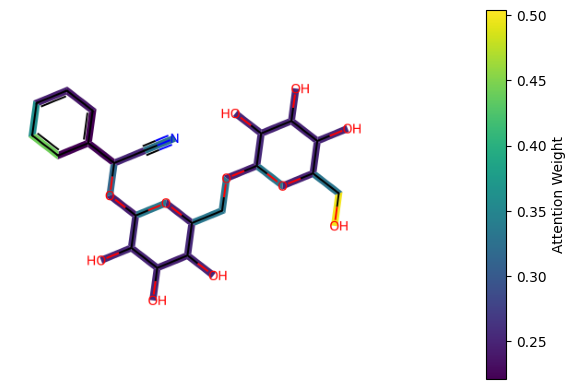

In [ ]:
img_bytes = drawer.GetDrawingText()
img = PILImage.open(io.BytesIO(img_bytes))
img_array = np.array(img)

# Setup plot with 2 columns: molecule + colorbar
fig, ax = plt.subplots(1, 2, figsize=(8, 4), gridspec_kw={'width_ratios': [12, 0.3]})

# Show molecule image
ax[0].imshow(img_array)
ax[0].axis('off')

# Create colorbar for attention weights
norm = Normalize(vmin=att_weights.min(), vmax=att_weights.max())
cbar = plt.colorbar(cm.ScalarMappable(norm=norm, cmap="viridis"), cax=ax[1])
cbar.set_label("Attention Weight")

plt.tight_layout()
plt.show()


Water solubility is generally influenced by polar groups such as hydroxyl (–OH) and cyano (–C≡N), which can form hydrogen bonds. The attention visualization suggests that the model may be focusing more on these groups when predicting solubility. In contrast, nonpolar regions like aromatic rings appear to receive less attention, possibly reflecting their smaller contribution. This pattern implies that the GNN could be learning chemically meaningful features relevant to solubility.

Make your own dataset: Molecular property prediction

The features for molecular graphs in ESOL is relatively naive, let's try to use more reasonable features:

In [ ]:
######################################################################################################################################################
########################### taken from https://github.com/chemprop/chemprop/blob/master/chemprop/features/featurization.py ###########################
######################################################################################################################################################

class Featurization_parameters:
    """
    A class holding molecule featurization parameters as attributes.
    """
    def __init__(self) -> None:

        # Atom feature sizes
        self.MAX_ATOMIC_NUM = 100
        self.ATOM_FEATURES = {
            'atomic_num': list(range(self.MAX_ATOMIC_NUM)),
            'degree': [0, 1, 2, 3, 4, 5],
            'formal_charge': [-1, -2, 1, 2, 0],
            'chiral_tag': [0, 1, 2, 3],
            'num_Hs': [0, 1, 2, 3, 4],
            'hybridization': [
                Chem.rdchem.HybridizationType.SP,
                Chem.rdchem.HybridizationType.SP2,
                Chem.rdchem.HybridizationType.SP3,
                Chem.rdchem.HybridizationType.SP3D,
                Chem.rdchem.HybridizationType.SP3D2
            ],
        }

        # Distance feature sizes
        self.PATH_DISTANCE_BINS = list(range(10))
        self.THREE_D_DISTANCE_MAX = 20
        self.THREE_D_DISTANCE_STEP = 1
        self.THREE_D_DISTANCE_BINS = list(range(0, self.THREE_D_DISTANCE_MAX + 1, self.THREE_D_DISTANCE_STEP))

        # len(choices) + 1 to include room for uncommon values; + 2 at end for IsAromatic and mass
        self.ATOM_FDIM = sum(len(choices) + 1 for choices in self.ATOM_FEATURES.values()) + 2
        self.EXTRA_ATOM_FDIM = 0
        self.BOND_FDIM = 14
        self.EXTRA_BOND_FDIM = 0
        self.REACTION_MODE = None
        self.EXPLICIT_H = False
        self.REACTION = False
        self.ADDING_H = False
        self.KEEP_ATOM_MAP = False

# Create a global parameter object for reference throughout this module
PARAMS = Featurization_parameters()

def onek_encoding_unk(value: int, choices: List[int]) -> List[int]:
    """
    Creates a one-hot encoding with an extra category for uncommon values.
    :param value: The value for which the encoding should be one.
    :param choices: A list of possible values.
    :return: A one-hot encoding of the :code:`value` in a list of length :code:`len(choices) + 1`.
             If :code:`value` is not in :code:`choices`, then the final element in the encoding is 1.
    """
    encoding = [0] * (len(choices) + 1)
    index = choices.index(value) if value in choices else -1
    encoding[index] = 1

    return encoding

In [ ]:
def atom_features(atom: Chem.rdchem.Atom, functional_groups: List[int] = None) -> List[Union[bool, int, float]]:
    """
    Builds a feature vector for an atom.
    :param atom: An RDKit atom.
    :param functional_groups: A k-hot vector indicating the functional groups the atom belongs to.
    :return: A list containing the atom features.
    """
    if atom is None:
        features = [0] * PARAMS.ATOM_FDIM
    else:
        features = onek_encoding_unk(atom.GetAtomicNum() - 1, PARAMS.ATOM_FEATURES['atomic_num']) + \
            onek_encoding_unk(atom.GetTotalDegree(), PARAMS.ATOM_FEATURES['degree']) + \
            onek_encoding_unk(atom.GetFormalCharge(), PARAMS.ATOM_FEATURES['formal_charge']) + \
            onek_encoding_unk(int(atom.GetChiralTag()), PARAMS.ATOM_FEATURES['chiral_tag']) + \
            onek_encoding_unk(int(atom.GetTotalNumHs()), PARAMS.ATOM_FEATURES['num_Hs']) + \
            onek_encoding_unk(int(atom.GetHybridization()), PARAMS.ATOM_FEATURES['hybridization']) + \
            [1 if atom.GetIsAromatic() else 0] + \
            [atom.GetMass() * 0.01]  # scaled to about the same range as other features
        if functional_groups is not None:
            features += functional_groups
    return features

atom_features(Chem.MolFromSmiles("CC=O").GetAtoms()[0])

[0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0.12011]

In [ ]:
def bond_features(bond: Chem.rdchem.Bond) -> List[Union[bool, int, float]]:
    """
    Builds a feature vector for a bond.
    :param bond: An RDKit bond.
    :return: A list containing the bond features.
    """
    if bond is None:
        fbond = [1] + [0] * (PARAMS.BOND_FDIM - 1)
    else:
        bt = bond.GetBondType()
        fbond = [
            0,  # bond is not None
            bt == Chem.rdchem.BondType.SINGLE,
            bt == Chem.rdchem.BondType.DOUBLE,
            bt == Chem.rdchem.BondType.TRIPLE,
            bt == Chem.rdchem.BondType.AROMATIC,
            (bond.GetIsConjugated() if bt is not None else 0),
            (bond.IsInRing() if bt is not None else 0)
        ]
        fbond += onek_encoding_unk(int(bond.GetStereo()), list(range(6)))
    return fbond

bond_features(Chem.MolFromSmiles("CC=O").GetBonds()[0])

[0, True, False, False, False, False, False, 1, 0, 0, 0, 0, 0, 0]

In [ ]:
######################################################################################################################################################
#################### modified from https://pytorch-geometric.readthedocs.io/en/latest/_modules/torch_geometric/utils/smiles.html #####################
######################################################################################################################################################

def smiles_to_graph(smiles: str, y: float, atm_idx=None, with_hydrogen: bool = False, kekulize: bool = False) -> 'torch.geometric.data.Data':
    """
    Converts a SMILES string to a :class:`torch_geometric.data.Data`
    instance.

    Args:
        smiles (str): The SMILES string.
        with_hydrogen (bool, optional): If set to :obj:`True`, will store
            hydrogens in the molecule graph. (default: :obj:`False`)
        kekulize (bool, optional): If set to :obj:`True`, converts aromatic
        bonds to single/double bonds. (default: :obj:`False`)
    """
    RDLogger.DisableLog('rdApp.*')

    mol = Chem.MolFromSmiles(smiles)

    if mol is None:
        mol = Chem.MolFromSmiles('')
    if with_hydrogen:
        mol = Chem.AddHs(mol)
    if kekulize:
        Chem.Kekulize(mol)

    xs = []
    for atom in mol.GetAtoms():
        xs.append(atom_features(atom))

    x = torch.tensor(xs, dtype=torch.long) #.view(-1, 9)

    edge_indices, edge_attrs = [], []
    for bond in mol.GetBonds():
        i = bond.GetBeginAtomIdx()
        j = bond.GetEndAtomIdx()

        e = []
        e.append(bond_features(bond))
        edge_indices += [[i, j], [j, i]]
        edge_attrs += [e, e]

    edge_index = torch.tensor(edge_indices)
    edge_index = edge_index.t().to(torch.long).view(2, -1)
    edge_attr = torch.tensor(edge_attrs, dtype=torch.long) # .view(-1, 3)

    if edge_index.numel() > 0:  # Sort indices.
        perm = (edge_index[0] * x.size(0) + edge_index[1]).argsort()
        edge_index, edge_attr = edge_index[:, perm], edge_attr[perm]

    if atm_idx is not None:
        return Data(x=x, edge_index=edge_index, edge_attr=torch.squeeze(edge_attr), y=torch.tensor([y], dtype=torch.float32), atm_idx=torch.tensor([atm_idx]))
    else:
        return Data(x=x, edge_index=edge_index, edge_attr=torch.squeeze(edge_attr), y=torch.tensor([y], dtype=torch.float32))

graph_temp = smiles_to_graph(smiles="CC=O", y=0.1)
print(graph_temp)
graph_temp.x, graph_temp.edge_index, graph_temp.edge_attr, graph_temp.y

Data(x=[3, 133], edge_index=[2, 4], edge_attr=[4, 14], y=[1])


(tensor([[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0,
          0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0,
          1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [ ]:
batch_size = 128
epochs = 50
hidden_channels = 64
num_layers = 5
lr = 0.0005

train_loader = DataLoader([smiles_to_graph(smiles=data.smiles, y=data.y.item()) for data in train_dataset], batch_size, shuffle=True)
test_loader = DataLoader([smiles_to_graph(smiles=data.smiles, y=data.y.item()) for data in test_dataset], batch_size, shuffle=False)

model = GraphAttention(in_channels=133, hidden_channels=hidden_channels, out_channels=1, num_layers=num_layers).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

train_loss_list = []
val_lost_list = []

for epcoh in range(1, epochs + 1):
        # Train
        model.train()
        for data_minibatch in train_loader:
                data_minibatch = data_minibatch.to(device)
                optimizer.zero_grad()
                out,_ = model(data_minibatch)
                loss = F.l1_loss(out, data_minibatch.y.unsqueeze(1))
                loss.backward()
                optimizer.step()

        # Evaluate on training set
        model.eval()
        total_loss_train = 0
        for data_minibatch in train_loader:
                data_minibatch = data_minibatch.to(device)
                pred,_ = model(data_minibatch)
                loss = F.l1_loss(pred, data_minibatch.y.unsqueeze(1))
                total_loss_train += float(loss) * data_minibatch.num_graphs

        # Evaluate on test set
        model.eval()
        total_loss_test = 0
        for data_minibatch in test_loader:
                data_minibatch = data_minibatch.to(device)
                pred,_ = model(data_minibatch)
                loss = F.l1_loss(pred, data_minibatch.y.unsqueeze(1))
                total_loss_test += float(loss) * data_minibatch.num_graphs

        total_loss_train /= len(train_dataset)
        total_loss_test /= len(test_dataset)

        train_loss_list.append(total_loss_train)
        val_lost_list.append(total_loss_test)

        print(f'Epoch: {epcoh:03d}, Train MAE: {total_loss_train:.4f}, Test MAE: {total_loss_test:.4f}')

Epoch: 001, Train MAE: 2.9943, Test MAE: 3.0006
Epoch: 002, Train MAE: 2.0981, Test MAE: 2.1539
Epoch: 003, Train MAE: 1.3242, Test MAE: 1.3209
Epoch: 004, Train MAE: 1.3747, Test MAE: 1.3570
Epoch: 005, Train MAE: 1.3588, Test MAE: 1.3994
Epoch: 006, Train MAE: 1.4183, Test MAE: 1.4710
Epoch: 007, Train MAE: 1.2755, Test MAE: 1.2857
Epoch: 008, Train MAE: 1.2769, Test MAE: 1.2715
Epoch: 009, Train MAE: 1.2740, Test MAE: 1.2937
Epoch: 010, Train MAE: 1.2757, Test MAE: 1.3004
Epoch: 011, Train MAE: 1.2396, Test MAE: 1.2553
Epoch: 012, Train MAE: 1.2083, Test MAE: 1.2202
Epoch: 013, Train MAE: 1.2182, Test MAE: 1.2428
Epoch: 014, Train MAE: 1.1562, Test MAE: 1.1630
Epoch: 015, Train MAE: 1.1496, Test MAE: 1.1786
Epoch: 016, Train MAE: 1.0558, Test MAE: 1.0738
Epoch: 017, Train MAE: 0.9777, Test MAE: 1.0055
Epoch: 018, Train MAE: 0.8801, Test MAE: 0.9005
Epoch: 019, Train MAE: 0.8693, Test MAE: 0.9138
Epoch: 020, Train MAE: 0.7713, Test MAE: 0.8045
Epoch: 021, Train MAE: 0.7816, Test MAE:

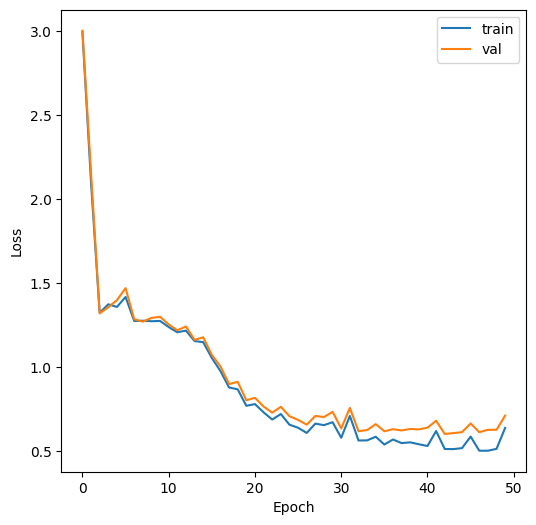

In [ ]:
# Plot learning curve
plt.figure(figsize=(6, 6))
plt.plot(train_loss_list, label='train')
plt.plot(val_lost_list, label='val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

RMSE =  0.95217067
R^2 =  0.7987927


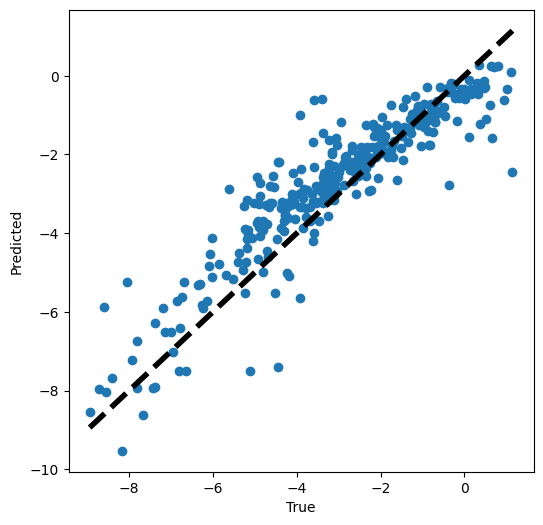

In [ ]:
y_true = []
y_pred = []
for data_minibatch in test_loader:
        data_minibatch = data_minibatch.to(device)
        pred,_ = model(data_minibatch)
        y_true.append(data_minibatch.y.cpu().detach().numpy())
        y_pred.append(pred.cpu().detach().numpy())

y_true = np.concatenate(y_true)
y_pred = np.concatenate(y_pred).reshape(-1)

RMSE = np.sqrt(np.mean((y_true - y_pred)**2))
print('RMSE = ', RMSE)

R_square = 1 - np.sum((y_true - y_pred)**2) / np.sum((y_true - np.mean(y_true))**2)
print('R^2 = ', R_square)

plt.figure(figsize=(6, 6))
plt.scatter(y_true, y_pred)
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'k--', lw=4)
plt.xlabel('True')
plt.ylabel('Predicted')
plt.show()